### Loading Libraries

In [ ]:
import os
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models

from PIL import Image

import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

### PATHS

In [2]:
dataset_folder = "dataset/Pakistan"
training_folder = os.path.join(dataset_folder, "Training")
validation_folder = os.path.join(dataset_folder, "Valid")

model_weights_path = "model_weights"

### Loading Dataset

In [3]:
def load_data(split_folder):

    data = {
        "class": [],
        "path": []

    }

    for class_folder in os.listdir(split_folder):

        if class_folder.endswith("back"):
            class_folder = class_folder[:-4]
        class_folder_full_path = os.path.join(split_folder, class_folder)
        class_folder_all_files = os.listdir(class_folder_full_path)

        for one_file in class_folder_all_files:

            one_file_full_path = os.path.join(class_folder_full_path, one_file)
            data["class"].append(class_folder)
            data["path"].append(one_file_full_path)

    return pd.DataFrame(data)

In [4]:
df_train = load_data(training_folder)
df_val = load_data(validation_folder)

### Data Analysis

<Axes: xlabel='class'>

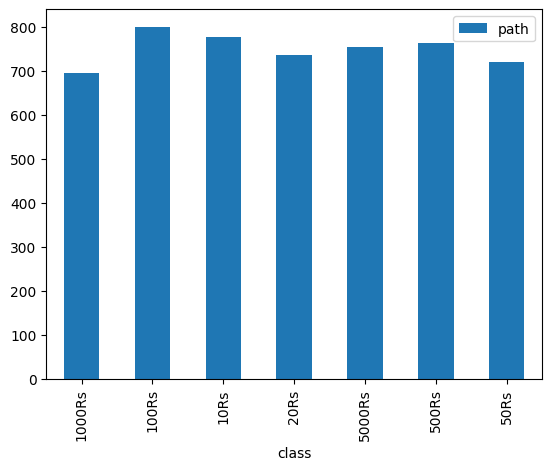

In [5]:
df_train.groupby("class").count().plot(kind="bar")

<Axes: xlabel='class'>

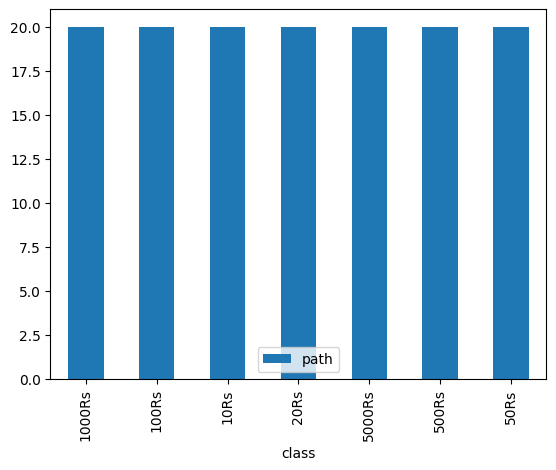

In [6]:
df_val.groupby("class").count().plot(kind="bar")

# Training

### Preprocessing

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

### Dataset and DataLoader

In [47]:
class ImageDFDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

        # If class column is strings, convert to integer labels
        self.df["label"] = self.df["class"]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img = Image.open(row["path"]).convert("RGB")
        label = class_mappings[row["label"]]

        if self.transform:
            img = self.transform(img)

        return img, label

In [48]:
train_dataset = ImageDFDataset(df_train, transform=train_transform)
test_dataset  = ImageDFDataset(df_val,  transform=test_transform)

In [49]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Hyperparamters

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

In [70]:
df_train["class"].unique()

class_mappings = {label:i for i, label in enumerate(df_train["class"].unique())}
class_mappings

{'1000Rs': 0,
 '100Rs': 1,
 '10Rs': 2,
 '20Rs': 3,
 '5000Rs': 4,
 '500Rs': 5,
 '50Rs': 6}

In [ ]:
def train_and_validate(model, num_epochs=100, patience=3):

    # -----------------------------
    # INIT MODEL
    # -----------------------------
    model = model(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(class_mappings))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    # -----------------------------
    # TRAIN + VALIDATE TOGETHER
    # -----------------------------
    for epoch in range(1, num_epochs + 1):

        # ===== TRAIN =====
        model.train()
        total_train_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # ===== VALIDATE =====
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(test_loader)
        val_acc = correct / total * 100

        print(
            f"Epoch {epoch} | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"Val Acc: {val_acc:.2f}%"
        )

        # ===== EARLY STOPPING =====
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_state = model.state_dict()  # save best model
        else:
            patience_counter += 1
            print(f"  No improvement. Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Restore best model
    if best_state is not None:
        model.load_state_dict(best_state)

    print("\nTraining complete.")
    print(f"Best Validation Loss: {best_val_loss:.4f}")

    return model

In [56]:
resnet_models = {
            "resnet18": models.resnet18, 
            "resnet34": models.resnet34, 
            "resnet50": models.resnet50
          }

for model_save_name, model in resnet_models.items():
    trained_model = train_and_validate(model)
    save_path = os.path.join(model_weights_path, f"{model_save_name}.pth")
    torch.save(trained_model.state_dict(), save_path)

    print(f"Saved {model_save_name} → {save_path}")

c:\Users\hp\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hp\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\hp/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:47<00:00, 994kB/s] 


Epoch 1 | Train Loss: 0.2853 | Val Loss: 0.4247 | Val Acc: 85.71%
Epoch 2 | Train Loss: 0.1098 | Val Loss: 0.1791 | Val Acc: 97.14%
Epoch 3 | Train Loss: 0.0607 | Val Loss: 0.4294 | Val Acc: 87.14%
  No improvement. Patience: 1/3
Epoch 4 | Train Loss: 0.0788 | Val Loss: 0.3724 | Val Acc: 91.43%
  No improvement. Patience: 2/3
Epoch 5 | Train Loss: 0.0440 | Val Loss: 0.0600 | Val Acc: 98.57%
Epoch 6 | Train Loss: 0.0481 | Val Loss: 0.1322 | Val Acc: 97.14%
  No improvement. Patience: 1/3
Epoch 7 | Train Loss: 0.0259 | Val Loss: 0.1369 | Val Acc: 97.14%
  No improvement. Patience: 2/3
Epoch 8 | Train Loss: 0.0243 | Val Loss: 0.4405 | Val Acc: 94.29%
  No improvement. Patience: 3/3
Early stopping triggered.

Training complete.
Best Validation Loss: 0.0600
Saved resnet18 → model_weights\resnet18.pth


c:\Users\hp\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\hp/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [01:29<00:00, 980kB/s] 


Epoch 1 | Train Loss: 0.3499 | Val Loss: 0.8307 | Val Acc: 82.86%
Epoch 2 | Train Loss: 0.1851 | Val Loss: 0.4493 | Val Acc: 90.00%
Epoch 3 | Train Loss: 0.0812 | Val Loss: 0.0700 | Val Acc: 97.14%
Epoch 4 | Train Loss: 0.0578 | Val Loss: 1.5676 | Val Acc: 84.29%
  No improvement. Patience: 1/3
Epoch 5 | Train Loss: 0.0666 | Val Loss: 0.3336 | Val Acc: 92.86%
  No improvement. Patience: 2/3
Epoch 6 | Train Loss: 0.0878 | Val Loss: 1.2528 | Val Acc: 78.57%
  No improvement. Patience: 3/3
Early stopping triggered.

Training complete.
Best Validation Loss: 0.0700
Saved resnet34 → model_weights\resnet34.pth


c:\Users\hp\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\hp/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [01:45<00:00, 970kB/s] 


Epoch 1 | Train Loss: 0.3915 | Val Loss: 0.5898 | Val Acc: 84.29%
Epoch 2 | Train Loss: 0.1914 | Val Loss: 0.1245 | Val Acc: 97.14%
Epoch 3 | Train Loss: 0.1327 | Val Loss: 0.1546 | Val Acc: 92.86%
  No improvement. Patience: 1/3
Epoch 4 | Train Loss: 0.1316 | Val Loss: 0.3289 | Val Acc: 94.29%
  No improvement. Patience: 2/3
Epoch 5 | Train Loss: 0.0957 | Val Loss: 0.5474 | Val Acc: 88.57%
  No improvement. Patience: 3/3
Early stopping triggered.

Training complete.
Best Validation Loss: 0.1245
Saved resnet50 → model_weights\resnet50.pth


### Loss Visualization

<Axes: >

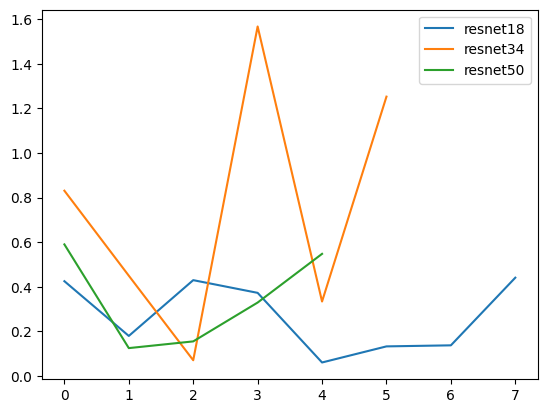

In [59]:
val_losses = {
    "resnet18": [0.4247, 0.1791, 0.4294, 0.3724, 0.0600, 0.1322, 0.1369, 0.4405],
    "resnet34": [0.8307, 0.4493, 0.0700, 1.5676, 0.3336, 1.2528, None, None],
    "resnet50": [0.5898, 0.1245, 0.1546, 0.3289, 0.5474,None,None,None]
}

df = pd.DataFrame(val_losses)

df.plot()

### Inference

In [ ]:
model_to_load = os.path.join(model_weights_path, "resnet18.pth")
image_to_test = "dataset/Pakistan/Valid/5000Rsback/IMG-20181013-WA0190 (2).jpg"
class_to_predict = "5000Rs"
label = class_mappings[class_to_predict]

4

In [ ]:
def inference(model_to_load, image_to_test, class_to_predict, label):

    device = "cuda" if torch.cuda.is_available() else "cpu"


    num_classes = len(class_mappings)
    model = models.resnet18(weights=None)   # no pretrained for loading weights
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_to_load, map_location=device))
    model = model.to(device)
    model.eval()


    img = Image.open(image_to_test).convert("RGB")
    img_tensor = test_transform(img).unsqueeze(0)  # add batch dim
    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        outputs = model(img_tensor)           # raw logits
        pred_class_idx = torch.argmax(outputs, dim=1).item()


    idx_to_class = {v: k for k, v in class_mappings.items()}
    pred_class_name = idx_to_class[pred_class_idx]

    return pred_class_name

In [99]:
classes = {
    "true_class": [],
    "predicted_class": []

}

model_to_load = os.path.join(model_weights_path, "resnet18.pth")

for class_folder in os.listdir(validation_folder):

    class_folder_full_path = os.path.join(validation_folder, class_folder)
    class_folder_all_files = os.listdir(class_folder_full_path)

    for one_file in class_folder_all_files:

        one_file_full_path = os.path.join(class_folder_full_path, one_file)
        class_to_predict = class_folder
        image_to_test = one_file_full_path

        classes["true_class"].append(class_to_predict)
        classes["predicted_class"].append(inference(model_to_load, image_to_test, class_to_predict, label))

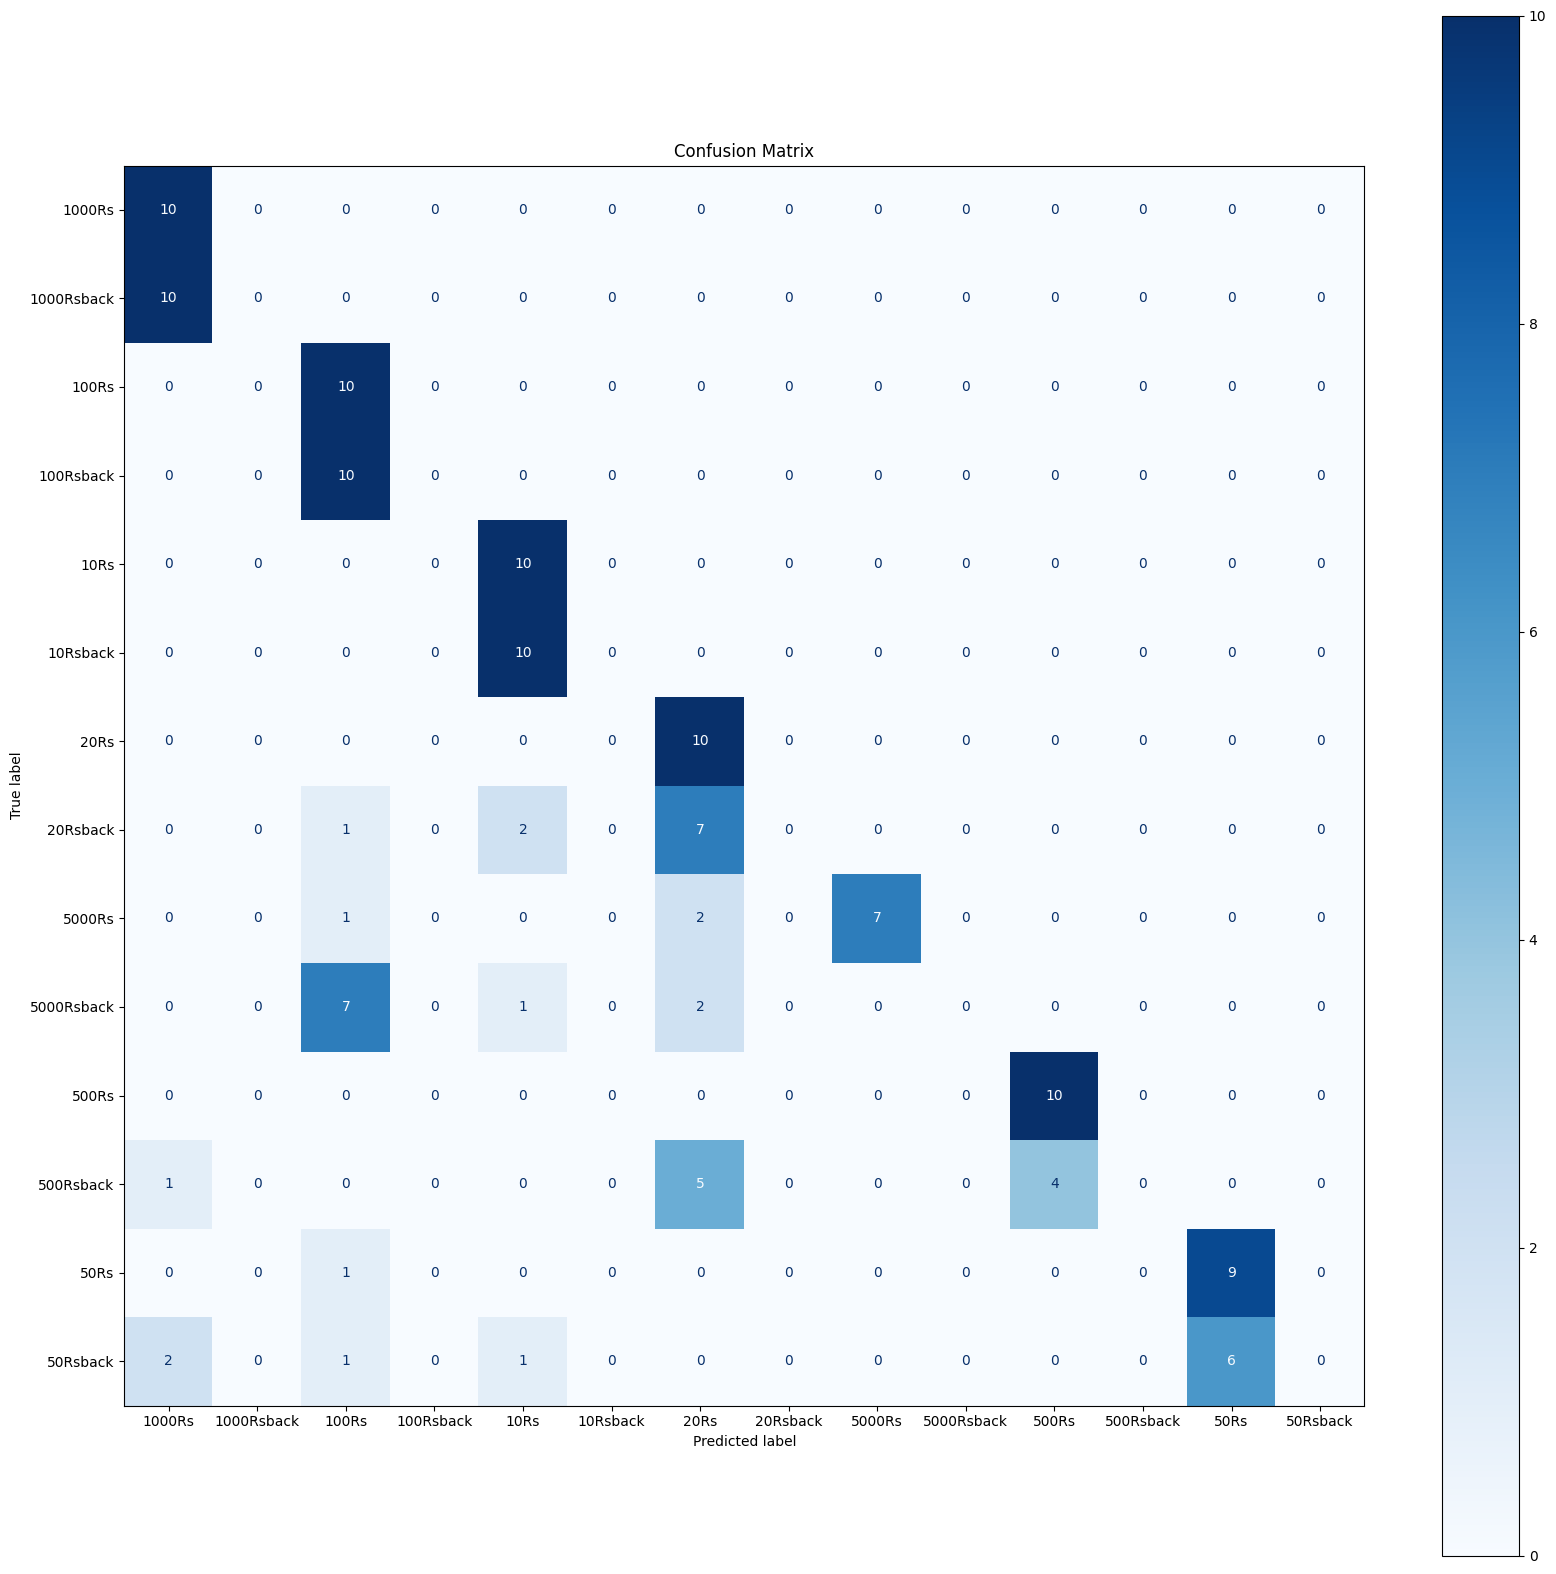

In [100]:
df = pd.DataFrame(classes)

y_true = df['true_class']
y_pred = df['predicted_class']

labels = sorted(list(set(y_true) | set(y_pred)))


cm = confusion_matrix(y_true, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)
plt.title("Confusion Matrix")
plt.show()

In [101]:
y_true = [x[:-4] if x.endswith("back") else x for x in y_true]
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, labels=labels, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, labels=labels, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, labels=labels, average='weighted', zero_division=0)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.8071
Precision: 0.8574
Recall   : 0.8071
F1-score : 0.7946


# Explanation of Results
### Model made no  error classifying 10, 100, 1000 rupees (front and back)
### Model also classified Rs 20 correctly but made few mistakes in classifying Rs 20 (back)
### Model also predicted alot 500, 5000 notes as Rs 20 incorrectly (Point to note is that it classified 500 rupees with 100% accuracy but it confused back of 500 rupees as 20 rupees often)
### Another important thing is that it failed to classify Rs. 5000 (back) correctly even once. It mostly confused it with Rs 100 notes.